## Google Colab setup

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
import sys
import os
print(sys.version)
!uname -a

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
Linux f9793f6b82a5 4.14.79+ #1 SMP Wed Dec 19 21:19:13 PST 2018 x86_64 x86_64 x86_64 GNU/Linux


In [0]:
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

In [0]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.version.cuda)

1
True
10.0.130


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
notebook_path = '/gdrive/My Drive/colab_data/notebooks'
os.chdir(notebook_path)

## Utils

In [0]:
%matplotlib inline

In [0]:
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import matplotlib.pyplot as plt

import pretty_midi

from tqdm import tqdm_notebook as tqdm
from collections import deque, Counter
from typing import Dict, List, Tuple

In [0]:
def midi_path_to_pianoroll(path: str, fs: int=5) -> np.ndarray:
    pmid = pretty_midi.PrettyMIDI(path)
    piano = pmid.instruments[0]
    pianoroll = piano.get_piano_roll(fs=fs)
    return pianoroll
    
def pianoroll_to_time_dict(pianoroll: np.ndarray) -> Dict[int, str]:
    times = np.unique(pianoroll.nonzero()[1])  # czasy gdzie występuje przynajmniej jedna nuta 
    index = pianoroll.nonzero()  # indeksy wszystkich nut
    dict_keys_time = {}

    for time in times:
        index_where = (index[1] == time).nonzero()  # pozycje nut, które występują w danym czasie, w indeksie
        notes = index[0][index_where]  # odszukanie nut
        dict_keys_time[time] = ','.join(notes.astype(str))
        
    return dict_keys_time


def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [0]:
class MIDIDataset:
    def __init__(self, converter, seq_len=50, song_batch_size=12, nn_batch_size=96):
        self.converter = converter
        self.seq_len = seq_len
        self.song_batch_size = song_batch_size
        self.nn_batch_size = nn_batch_size
        self._pos = 0
        self._song_batch = None
        
    def get_batch(self):
        if self._song_batch is None:
            songs_train, songs_target = self.converter.get_batch(self.song_batch_size, self.seq_len)
            shuffle_order = np.random.permutation(np.arange(songs_target.shape[0]))
            songs_train = songs_train[shuffle_order, :]
            songs_target = songs_target[shuffle_order]
            self._song_batch = (songs_train, songs_target)
            self._pos = 0
            
        songs_train, songs_target = self._song_batch
        end_pos = min(self._pos + self.nn_batch_size, songs_target.shape[0])
        train_batch, target_batch = songs_train[self._pos:end_pos, :], songs_target[self._pos:end_pos]
        if end_pos == songs_target.shape[0]:
            self._song_batch = None
        self._pos = end_pos
        return train_batch, target_batch

    def unique_notes(self):
        return self.converter.unique_notes()
    
    def sample_start(self, n=1):
        frequency = self.converter.notes_frequency()
        notes = np.zeros(shape=self.seq_len)
        for i in range(1,n+1):
            notes[-i] = np.argmax(np.random.multinomial(1, frequency))
        return notes
    
    def to_midi(self, sequence):
        pianoroll = self.converter.sequence_to_pianoroll(sequence)
        generate_to_midi = piano_roll_to_pretty_midi(pianoroll, fs=self.converter.fs)
        for note in generate_to_midi.instruments[0].notes:
            note.velocity = 100
        return generate_to_midi
        
        
class MIDIConverter:
    def __init__(self, directory: str, frac: float=0.1, fs: int=30) -> None:
        assert 0 < frac <= 1
        self.fs = fs
        self._paths = self._locate_midi_files(directory, frac)
        self._time_dicts, self._notes_mapping, self._notes_frequency = self._convert_to_time_dicts()
        self._inverse_notes_mapping = {v: k for k, v in self._notes_mapping.items()}
        
    def get_batch(self, batch_size, seq_len):
        idx = np.random.choice(len(self._paths), size=batch_size)
        batch_train, batch_target = [], []
        for i in idx:
            time_dict = self._time_dicts[i]
            train_vals, target_vals = self._time_dict_to_seq(time_dict, seq_len)
            batch_train.append(train_vals)
            batch_target.append(target_vals)
        return np.vstack(batch_train), np.hstack(batch_target)
        
    def unique_notes(self):
        return len(self._notes_mapping)
    
    def notes_frequency(self):
        total = sum(self._notes_frequency.values())
        freqs = np.zeros(shape=(len(self._notes_mapping) + 1), dtype=np.float64)
        for note, idx in self._notes_frequency.items():
            freqs[idx] = self._notes_frequency[note] / total
        return freqs
    
    def sequence_to_pianoroll(self, sequence):
        notes = [[int(note) for note in self._inverse_notes_mapping.get(idx, '-1').split(',')] for idx in sequence]
        pianoroll = np.zeros(shape=(128, len(notes)))
        for i, note_idx in enumerate(notes):
            if note_idx != -1:
                pianoroll[note_idx, i] = 1
        return pianoroll
        
        
    def _time_dict_to_seq(self, time_dict, seq_len) -> np.ndarray:
        times = list(time_dict.keys())
        start_time, end_time = np.min(times), np.max(times)
        n_samples = end_time - start_time
        initial_values = [0]*(seq_len-1) + [time_dict[start_time]]
        train_values = np.zeros(shape=(n_samples+1, seq_len))
        target_values = np.zeros(shape=(n_samples+1))
        train_values_per_step = deque(initial_values)
        for i in range(n_samples):
            train_values[i, :] = list(train_values_per_step)
            current_target = time_dict.get(start_time + i, 0)
            target_values[i] = current_target
            train_values_per_step.popleft()
            train_values_per_step.append(current_target)
        train_values[n_samples, :] = list(train_values_per_step)
        return train_values, target_values
        
    def _convert_to_time_dicts(self) -> Tuple[Dict[int, Dict[int, str]], Dict[str, int]]:
        unique_notes = list()
        time_dicts = {}
        for i, path in tqdm(enumerate(self._paths), total=len(self._paths)):
            pianoroll = midi_path_to_pianoroll(path, fs=self.fs)
            time_dict = pianoroll_to_time_dict(pianoroll)
            time_dicts[i] = time_dict
            unique_notes += list(time_dict.values())

        notes_freq = Counter(unique_notes)
        unique_notes = set(unique_notes)
        # Replace strings with oridinal encoding
        notes_mapping = {note:(i+1) for i, note in enumerate(unique_notes)}
        for i, time_dict in time_dicts.items():
            for time, notes in time_dict.items():
                time_dict[time] = notes_mapping[notes]
        return time_dicts, notes_mapping, notes_freq
            
    def _locate_midi_files(self, base_dir: str, frac: float) -> List[str]:
        midi_files = []
        for root, dirs, files in os.walk(base_dir):
            for file in files:
                if file.endswith('.midi') or file.endswith('.mid'):
                    midi_files.append(os.path.join(root, file))
        return np.random.choice(midi_files, size=int(frac*len(midi_files)), replace=False)

In [0]:
class MusicRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, unique_notes, seq_len, rnn='LSTM'):
        assert rnn in ['LSTM', 'GRU']
        super().__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(unique_notes+1, embedding_dim)
        if rnn == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, dropout=0.2)
        else:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=3, dropout=0.2)
        self.linear = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * seq_len, 512),
            nn.LeakyReLU(),
            nn.Linear(512, unique_notes+1)
        )

    def forward(self, x):
        batch_size, _ = x.shape
        embeds = self.embeddings(x)
        rnn_out, _ = self.rnn(embeds.view(self.seq_len, batch_size, -1))
        outputs = self.linear(rnn_out.view(batch_size, -1))
        return outputs

In [0]:
def generate_sample(model, provider, length=50, temperature=1.0, device='cpu'):
    notes = deque(provider.sample_start(1))
    generated = [notes[-1]]
    for i in range(length-1):
        data = torch.tensor(data=np.expand_dims(np.array(notes), axis=0), dtype=torch.long).to(device)
        output = F.softmax(model(data) / temperature, dim=1).cpu()
        output = torch.clamp(output, min=0)
        new_note = torch.multinomial(output, 1)[:, 0]
        new_note = new_note.item()
        notes.popleft()
        notes.append(new_note)
        generated.append(new_note)
    return generated

In [0]:
def train(model, provider, optimizer, criterion, iterations, device, model_comb, scheduler=None):
    mean_losses = []
    losses = []
    try:
        for iteration in tqdm(range(iterations)):
            if not scheduler is None:
                scheduler.step()
            data, targets = provider.get_batch()
            data, targets = torch.tensor(data=data, dtype=torch.long).to(device), torch.tensor(data=targets, dtype=torch.long).to(device)
            model.zero_grad()

            target_preds = F.log_softmax(model(data), dim=1)

            loss = criterion(target_preds, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
            if len(losses) == 1000:
                mean_losses.append(np.mean(losses))
                losses = []
        
            if iteration % 100000 == 0 or iteration == iterations - 1:
                with torch.no_grad():
                    sample = generate_sample(model, provider, device=device, length=100, temperature=1.0)
                    midi = provider.to_midi(sample)
                    midi.write(f'../music/{model_comb}/sample_{iteration}.midi')
    except KeyboardInterrupt:
        pass

    return mean_losses

## Train

In [0]:
dataset='chopin'
dataset_path = f'../midi/{dataset}'
fs = 5
seq_len = 50
embed_size = 128
rnn_type = 'LSTM'

model_comb = f'{rnn_type.lower()}3_{embed_size}_{seq_len}_sgd_{dataset}'

if not os.path.exists(f'../music/{model_comb}'):
  os.makedirs(f'../music/{model_comb}')
if not os.path.exists(f'../models/{model_comb}'):
  os.makedirs(f'../models/{model_comb}')


converter = MIDIConverter(dataset_path, frac=1.0, fs=fs)
provider = MIDIDataset(converter, nn_batch_size=64, song_batch_size=8, seq_len=seq_len)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:0


In [0]:
model = MusicRNN(embedding_dim=embed_size, hidden_dim=512, unique_notes=provider.unique_notes(), seq_len=seq_len, rnn=rnn_type)
model = model.to(device)
loss = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = train(model, provider, optimizer, loss, 200000, device, model_comb)

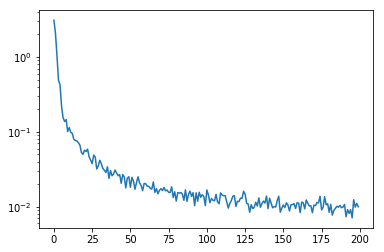

In [0]:
torch.save(model.state_dict(), f'../models/{model_comb}/model.pb')

fig = plt.figure()
plt.plot([i for i in range(len(losses))], losses)
plt.yscale('log')
plt.savefig(f'../models/{model_comb}/losses.png')

## Load model

In [0]:
std = torch.load('../models/lstm3_128_50_chopin/model.pb', map_location=device)
model.load_state_dict(std)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
from torch.utils.tensorboard import SummaryWriter

In [0]:
writer = SummaryWriter(log_dir='../tensorboard')

mtd = ['break'] + [k[0] for k in sorted(provider.converter._notes_mapping.items(), key=lambda x: x[1])]
writer.add_embedding(mat=model.embeddings.weight.data.numpy(), metadata=mtd)
writer.close()

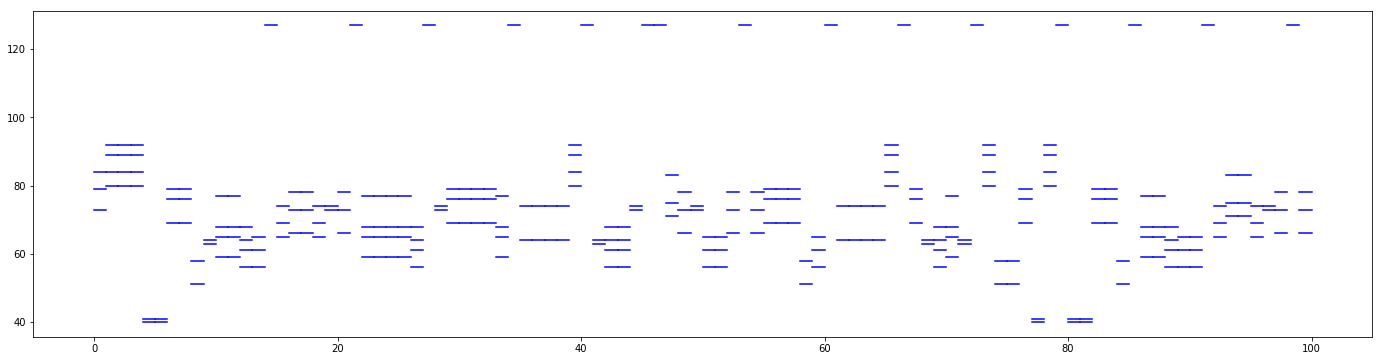

In [0]:
plt.figure(figsize=(24, 6))
sample = generate_sample(model, provider, device=device, length=100, temperature=1)
pr = provider.converter.sequence_to_pianoroll(sample)
for i in range(pr.shape[1]):
    notes = np.nonzero(pr[:, i])
    for note in notes:
        plt.plot([i, i+1], [note, note], color='blue')
    

In [0]:
midi = provider.to_midi(sample)
midi.write('../music/lstm3_128_50_chopin/hello.midi')

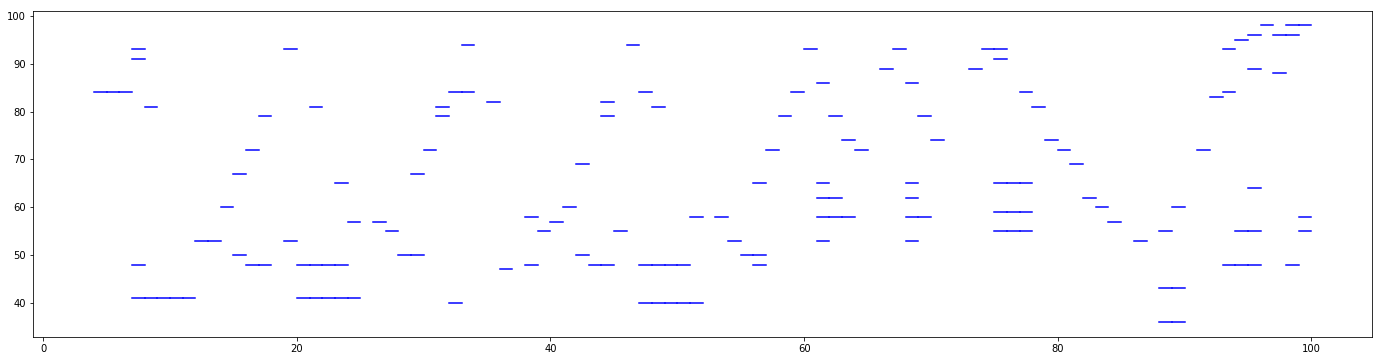

In [0]:
plt.figure(figsize=(24, 6))
original_pr = midi_path_to_pianoroll('/home/bartek/Datasets/maestro/2008/MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--4.midi', fs=5)
for i in range(100):
    notes = np.nonzero(original_pr[:100, i])[0]
    
    for note in notes:
        plt.plot([i, i+1], [note, note], color='blue')
    